In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import random
from Hidden_NB import Hidden_NB
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from copy import deepcopy
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

# Introduction

The goal of this notebook is to compare the classification ability of the Hidden Naive Bayes Classifier that of the Multinomial Bayes Classifier on the balance-scale dataset.  The balance-scale dataset was chosen because it only includes only integer features, with which both classifiers are compatible.  In the future, more datasets should be used to confirm the results of this notebook.

# Importing and Splitting Data

The balance-scale data set contains 625 records with 4 features and 1 target.  The 4 features are all integer.

In [3]:
balance = pd.read_csv('./balance-scale.data', names=['class', 'left_weight', 'left_distance', 
                                                       'right_weight', 'right_distance'])
balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625 entries, 0 to 624
Data columns (total 5 columns):
class             625 non-null object
left_weight       625 non-null int64
left_distance     625 non-null int64
right_weight      625 non-null int64
right_distance    625 non-null int64
dtypes: int64(4), object(1)
memory usage: 24.5+ KB


First, the data will need to be split into a training set and test set (later, with cross-validation, this will be performed within the cross-validation function).

In [4]:
X = balance.drop(columns=['class'])
y = balance['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,
                                                         random_state=33)

We'll also take a quick look at the distributions of the varieties so that we can choose proper evaluation metrics.

In [5]:
balance['class'].value_counts()

L    288
R    288
B     49
Name: class, dtype: int64

The classes are not balanced so micro evaluation measures will be used.

# Classification Reports

A classification report will now be generated for the Hidden Naive Bayes classifier and the Naive Bayes Multinomial Classifier.

In [6]:
np.random.seed(4252)

First, a classification report for the Naive Bayes Multinomial Classifier will be generated to set a baseline.

In [7]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
y_predict = mnb.predict(X_test)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           B       0.00      0.00      0.00        12
           L       0.97      0.95      0.96        60
           R       0.77      0.96      0.86        53

   micro avg       0.86      0.86      0.86       125
   macro avg       0.58      0.64      0.61       125
weighted avg       0.79      0.86      0.82       125



/home/sam/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sam/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sam/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Now the same will be done with the Hidden Naive Bayes Classifier.

In [8]:
hnb = Hidden_NB()
hnb.fit(X_train, y_train)
y_predict = hnb.predict(X_test)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           B       0.50      0.17      0.25        12
           L       0.90      0.93      0.92        60
           R       0.86      0.96      0.91        53

   micro avg       0.87      0.87      0.87       125
   macro avg       0.76      0.69      0.69       125
weighted avg       0.85      0.87      0.85       125



Notice how the Multinomial Naive Bayes classifier was not able to classify any of the class 'B' whereas the Hidden Naive Bayes classifier was able to 2 of them.

Using these numbers alone would suggest that the Hidden Naive Bayes Classifier performs better in terms of precision and recall.  However, these numbers are generated from a single random test set so strong conclusions cannot be drawn.



# Cross Validation Bootstrap

For a more complete comparison of the two classifiers performance, a 10 fold cross-validation will performed 3 times and bootstrap samples will be taken from the scores to develop a credible interval for each.

In [9]:
np.random.seed(90392)

In [10]:
def bootstrap_sample(data, f, n=100):
    
    results = []
    for _ in range(n):
        sample = np.random.choice(data, len(data), replace=True)
        r = f(sample)
        results.append(r)
    
    return np.array(results)

In [11]:
def multi_cross_val(data, target, estimator, cv=5, n=6):
    
    scores = {'precision': np.array([]), 
              'recall': np.array([]),
              'f1': np.array([])}
    
    
    for _ in range(n):
        
        kf = KFold(n_splits=cv, shuffle=True)
        
        for train_index, test_index in kf.split(data):
            
            train = data.loc[train_index]
            test = data.loc[test_index]
            
            estimator.fit(train.drop(columns=[target]), train[target])
            y_predict = estimator.predict(test.drop(columns=[target]))
            precision = precision_score(test[target], y_predict, average='micro')
            recall = recall_score(test[target], y_predict, average='micro')
            f1 = f1_score(test[target], y_predict, average='micro')
            
        
            scores['precision'] = np.append(scores['precision'], precision)
            scores['recall'] = np.append(scores['recall'], recall)
            scores['f1'] = np.append(scores['f1'], f1)
        
    return scores

**Multinomial Naive Bayes Classifier** cross-validation bootstrap

In [12]:
# Get scores
scores_mnb = multi_cross_val(balance, 'class', MultinomialNB())

# Resample Scores
precision_mnb_resample = bootstrap_sample(scores_mnb["precision"], np.mean)
recall_mnb_resample = bootstrap_sample(scores_mnb["recall"], np.mean)
f1_mnb_resample = bootstrap_sample(scores_mnb["f1"], np.mean)

# Find credible intervals
precision_mnb_cred = np.array2string(stats.mstats.mquantiles(precision_mnb_resample, [0.25, .975]), precision=3, separator=',')
recall_mnb_cred = np.array2string(stats.mstats.mquantiles(recall_mnb_resample, [0.25, .975]), precision=3, separator=',')
f1_mnb_cred = np.array2string(stats.mstats.mquantiles(f1_mnb_resample, [0.25, .975]), precision=3, separator=',')

# Print results
print("precision Resample Mean: {0:.3f}".format(np.mean(precision_mnb_resample)))
print("95% Credible Interval for precision: ", precision_mnb_cred)
print("recall Resample Mean: {0:.3f}".format(np.mean(recall_mnb_resample)))
print("95% Credible Interval for recall: ", recall_mnb_cred)
print("f1 Resample Mean: {0:.3f}".format(np.mean(f1_mnb_resample)))
print("95% Credible Interval for f1: ", f1_mnb_cred)

precision Resample Mean: 0.871
95% Credible Interval for precision:  [0.868,0.88 ]
recall Resample Mean: 0.872
95% Credible Interval for recall:  [0.869,0.88 ]
f1 Resample Mean: 0.871
95% Credible Interval for f1:  [0.868,0.879]


**Hidden Naive Bayes Classifier** cross-validation bootstrap

In [13]:
# Get scores
scores_hnb = multi_cross_val(balance, 'class', Hidden_NB())

# Resample Scores
precision_hnb_resample = bootstrap_sample(scores_hnb["precision"], np.mean)
recall_hnb_resample = bootstrap_sample(scores_hnb["recall"], np.mean)
f1_hnb_resample = bootstrap_sample(scores_hnb["f1"], np.mean)

# Find credible intervals
precision_hnb_cred = np.array2string(stats.mstats.mquantiles(precision_hnb_resample, [0.25, .975]), precision=3, separator=',')
recall_hnb_cred = np.array2string(stats.mstats.mquantiles(recall_hnb_resample, [0.25, .975]), precision=3, separator=',')
f1_hnb_cred = np.array2string(stats.mstats.mquantiles(f1_hnb_resample, [0.25, .975]), precision=3, separator=',')

# Print results
print("precision Resample Mean: {0:.3f}".format(np.mean(precision_hnb_resample)))
print("95% Credible Interval for precision: ", precision_hnb_cred)
print("recall Resample Mean: {0:.3f}".format(np.mean(recall_hnb_resample)))
print("95% Credible Interval for recall: ", recall_hnb_cred)
print("f1 Resample Mean: {0:.3f}".format(np.mean(f1_hnb_resample)))
print("95% Credible Interval for f1: ", f1_hnb_cred)

precision Resample Mean: 0.880
95% Credible Interval for precision:  [0.877,0.89 ]
recall Resample Mean: 0.880
95% Credible Interval for recall:  [0.877,0.889]
f1 Resample Mean: 0.881
95% Credible Interval for f1:  [0.878,0.89 ]


The credible intervals overlap with a slight advantage to the Hidden Naive Bayes Classifier. The distribution for each algorithm and each statistic will now be plotted with a histogram.

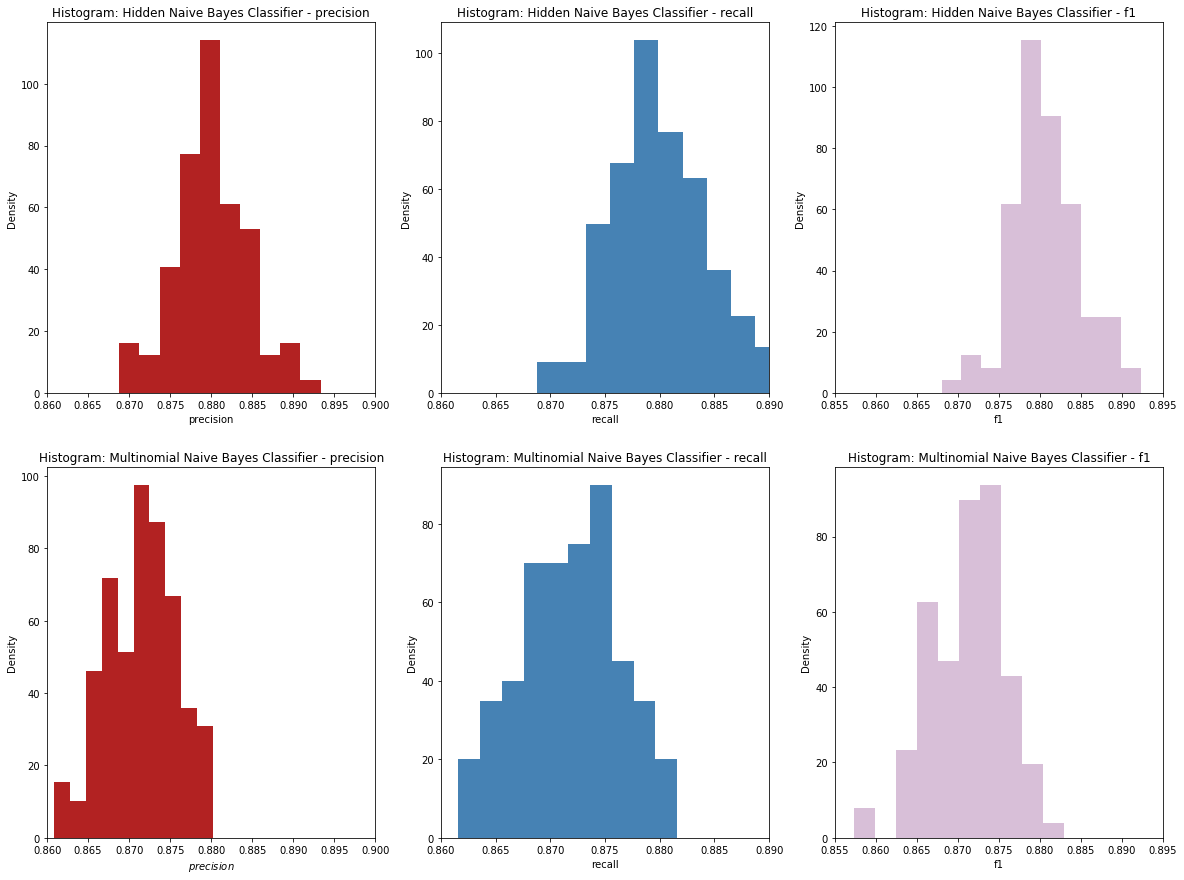

In [14]:
figure = plt.figure(figsize=(20, 15))

axes = figure.add_subplot(2, 3, 1)
axes.hist(precision_hnb_resample, color='firebrick', density=True)
axes.set_ylabel("Density")
axes.set_xlabel("precision")
axes.set_title("Histogram: Hidden Naive Bayes Classifier - precision")
axes.set_xlim([.86, .90])

axes = figure.add_subplot(2, 3, 4)
axes.hist(precision_mnb_resample, color='firebrick', density=True)
axes.set_ylabel("Density")
axes.set_xlabel("$precision$")
axes.set_title("Histogram: Multinomial Naive Bayes Classifier - precision")
axes.set_xlim([.86, .90])


axes = figure.add_subplot(2, 3, 2)
axes.hist(recall_hnb_resample, color='steelblue', density=True)
axes.set_ylabel("Density")
axes.set_xlabel("recall")
axes.set_title("Histogram: Hidden Naive Bayes Classifier - recall")
axes.set_xlim([.86, .89])

axes = figure.add_subplot(2, 3, 5)
axes.hist(recall_mnb_resample, color='steelblue', density=True)
axes.set_ylabel("Density")
axes.set_xlabel("recall")
axes.set_title("Histogram: Multinomial Naive Bayes Classifier - recall")
axes.set_xlim([.86, .89])

axes = figure.add_subplot(2, 3, 3)
axes.hist(f1_hnb_resample, color='thistle', density=True)
axes.set_ylabel("Density")
axes.set_xlabel("f1")
axes.set_title("Histogram: Hidden Naive Bayes Classifier - f1")
axes.set_xlim([.855, .895])

axes = figure.add_subplot(2, 3, 6)
axes.hist(f1_mnb_resample, color='thistle', density=True)
axes.set_ylabel("Density")
axes.set_xlabel("f1")
axes.set_title("Histogram: Multinomial Naive Bayes Classifier - f1")
axes.set_xlim([.855, .895])

plt.show()
plt.close()

While each distribution overlaps, it's clear that the Hidden Naive Bayes Classifier scores in better with all statistics.  Now, the difference will be plotted.

In [15]:
difference = {}
difference["precision"] = precision_hnb_resample - precision_mnb_resample
difference["recall"] = recall_hnb_resample - recall_mnb_resample
difference["f1"] = f1_hnb_resample - f1_mnb_resample

Text(0.5, 1.0, 'Histogram: Difference - f1')

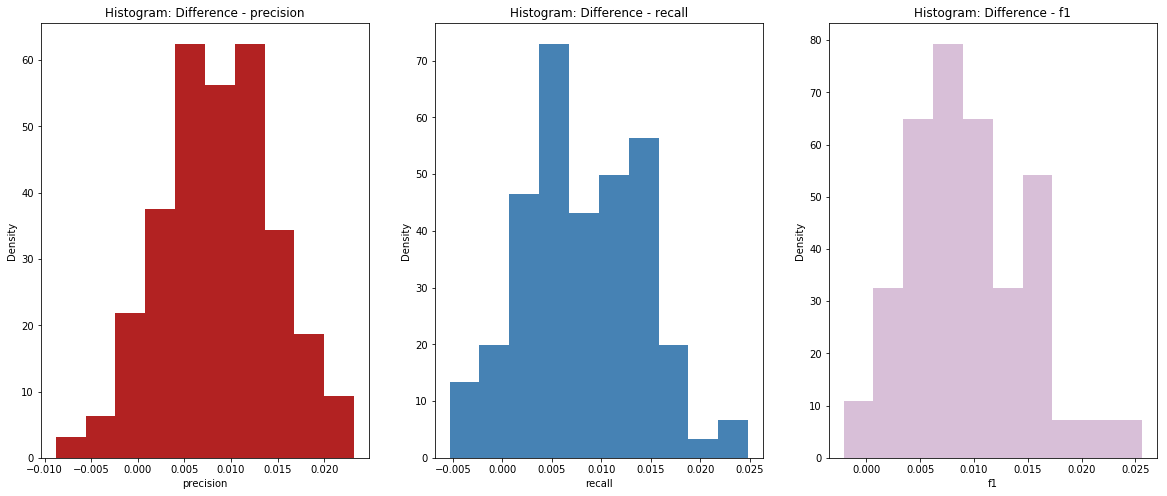

In [16]:
figure = plt.figure(figsize=(20, 8))

axes = figure.add_subplot(1, 3, 1)
axes.hist(difference["precision"], color='firebrick', density=True)
axes.set_ylabel("Density")
axes.set_xlabel("precision")
axes.set_title("Histogram: Difference - precision")

axes = figure.add_subplot(1, 3, 2)
axes.hist(difference["recall"], color='steelblue', density=True)
axes.set_ylabel("Density")
axes.set_xlabel("recall")
axes.set_title("Histogram: Difference - recall")

axes = figure.add_subplot(1, 3, 3)
axes.hist(difference["f1"], color='thistle', density=True)
axes.set_ylabel("Density")
axes.set_xlabel("f1")
axes.set_title("Histogram: Difference - f1")

In [17]:
print("P(precision Hidden Naive Bayes > precision Multinomial Naive Bayes) = ", np.mean(difference["precision"]>0))
print("P(recall Hidden Naive Bayes < recall Multinomial Naive Bayes) = ", np.mean(difference["recall"]>0))
print("P(f1 Hidden Naive Bayes < recall Multinomial Naive Bayes) = ", np.mean(difference["f1"]>0))

P(precision Hidden Naive Bayes > precision Multinomial Naive Bayes) =  0.9
P(recall Hidden Naive Bayes < recall Multinomial Naive Bayes) =  0.91
P(f1 Hidden Naive Bayes < recall Multinomial Naive Bayes) =  0.97


This suggests that the Hidden Naive Bayes Classifier almost certainly performs better in general on the balance-scale dataset in terms of precision, recall, and f1.  Further testing on other datasets would need to be performed to confirm this in general.  However, in the original paper, "A Novel Bayes Model: Hidden Naive Bayes" by Jiang, Zhang, and Chai, the authors tested the algorithm on a variety of datasets where it classified more accurately than the standard Naive Bayes Classifier as well as other similar algorithms. 